In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pytensor.tensor as pt
import pdfplumber
import xarray as xr
sns.set_style("whitegrid")
import os,glob,sys
from pytensor.scan import scan
from importlib import reload

from pathlib import Path

repo_root = Path.cwd().parents[0]
sys.path.insert(0, str(repo_root))

from utils import damip_utils
from bayes import attribution

In [2]:
for_talk=False
if for_talk:
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    apha=.7
    obsc="w"

else:
    plt.style.use("default")
    obsc="k"
    apha=.3

# DATA 

## Read in DAMIP simulations

In [3]:
GCM_F=damip_utils.read_DAMIP_simulations()

hist-GHG:   0%|          | 0/14 [00:00<?, ?it/s]

hist-CO2:   0%|          | 0/3 [00:00<?, ?it/s]

hist-aer:   0%|          | 0/13 [00:00<?, ?it/s]

hist-nat:   0%|          | 0/14 [00:00<?, ?it/s]

historical:   0%|          | 0/12 [00:00<?, ?it/s]

piControl:   0%|          | 0/13 [00:00<?, ?it/s]

## Read in HadCRUT

In [4]:
H_obs = damip_utils.read_HadCRUT()

## Read in CO2 emissions

In [5]:
cumu=damip_utils.read_emissions()
mu_E = cumu.sel(time=slice(1850,2014)).mean(dim="sample").values
sigma_E=  cumu.sel(time=slice(1850,2014)).std(dim="sample").values   

# MODEL

## 1. Model for observations
We assume the observations are the sum of the global mean temperature response $R_i$ to various forcings $i$ and internal variability $\epsilon$:

$$T_{obs} = \sum_{i} R_i + \epsilon$$

## 2. Model for internal variability
We model the unobservable internal variability 
$$\epsilon \sim AR_p(\rho,\sigma_{innov})$$

Here, $\rho$ is a $p$-dimensional vector correponding to the lag correlations.  If $p=1$, then the internal variability is red noise: the temperature in any given year is correlated with the temperature in the year previously.  If $\rho=2$ it depends on the two previous years, and so on. We characterize the noise by an AR(3) process, which appears to be the model that best fits the pre-industrial control run data (not shown). (We could also use a sum of AR(1) processes as in Ribes et al 2021 but this is easier).

We also use individual pre-industrial control runs to constrain the posteriors for $\rho$ and $\sigma$:

$$C^j \sim AR_p(\rho,\sigma_{innov})$$.



## 3. Model for responses

Clearly, the real-world responses to external forcings are unobservable.  We model the observed responses using a standard regression model 

$$
R_i = s_i F_i
$$

where $F_i$ is the fingerprint of forcing $i$, defined as the physically expected spatiotemporal (in this case, temporal) response pattern.  The scaling factors (commonly referred to as  $\beta_i$ but denoted $s_i$ here to avoid confusion with the CO2 fertilization effect) quantify the extent to which the observations match the searched-for fingerprints.  

## 4. Model for fingerprints

But what are the fingerprints?  Many different approaches have been proposed to estimate the climate response to external forcings (RFMIP approach, scaling of emissions or concentrations, simple box models or other reduced-complexity models).   

Here, we estimate the searched-for fingerprints from simulations performed with CMIP6 models as part of the Detection and Attribution Model Intercomparison Project (DAMIP).  CMIP is not an "ensemble" in any true statistical sense of the word; it has often been referred to as an "ensemble of opportunity".  This means that in order to make inferences about the real-world values of the quantities simulated by CMIP, we require a model that links the two.   Here, we use a random-effects model to account for internal variability within the models and structural differences between the models.  Any individual simulation run with forcing $i$ reflects the model-specific response $\Theta_{i,(m)}(t)$ and the model-specific internal variability (with amplitude $\sigma_{(m)}$ ).  The  $j$-th member of the ensemble provided by CMIP6 model $m$ is therefore assumed to be normally distributed:
$$
y^j_{i,(m)} \sim N(\Theta_{i,(m)}(t),\sigma_{(m)}).
$$
The forced response in each model is then assumed to differ from the true forced response by a bias term $b_m$ and a term $\sigma_{structural}$  
$$
\Theta_{i,(m)}(t) \sim N(F_i-b_{m},\sigma_{structural}).
$$

# NOTE: Almost all the CMIP6 models give the same temporal behavior in response to forcings: aerosols start to decrease the temperature at the same time and flatline at the same time.  The main differences are in magnitude, not time evolution.  So these results are very confident in what the fingerprints "should" be, and thus the TCRE is very constrained. This is because a DAMIP-alone analysis does not provide any evidence that the DAMIP simulations are wrong/incomplete/forced inaccurately.  If we want to incorporate this possibility, WE NEED EVIDENCE.  
## We can also specify this in the priors, but we need a rationale to do so.

# PRIORS 
## Internal variability
Here, we assume no knowledge about the lag coefficients and a wide prior on the white noise component of the internal variability.

In [8]:
n_ar=3
internal_variability_priors={}
internal_variability_priors["rho"]=lambda name: pm.Uniform(name,-1,1,shape=(n_ar))
internal_variability_priors["sigma_innovation"]=lambda name: pm.HalfNormal(name,10)

## CMIP 
In order to interpret the CMIP evidence, we need to put priors on the
* CMIP6 multi-model response to each forcing $F_{mean}$ (we assume the same prior distribution for every forcing $i$, updated separately for each forcing). 
* model-specific internal variability $\sigma_{internal}$ (same prior for every model, updated separately for every model)
* inter-model spread $\sigma_{structural}$

In [67]:
# Specify priors on CMIP
cmip_priors={}
# Prior on internal variability amplitude in each model
cmip_priors["sigma_internal"] = lambda name: pm.HalfNormal(name,1.)
# Prior on inter-model spread 
# Make it pretty wide: the models could be wildly different from one another
cmip_priors["sigma_structural"] = lambda name: pm.HalfNormal(name,100.)
#EXAMPLE: Don't estimate it, set it from model spread and don't update
#cmip_priors["sigma_structural"] = lambda name: 

# Prior on the "true" multi-model forced response
# This one is super wide
cmip_priors["F_mean"] = lambda name: pm.Normal(name,0,10,dims=("time",))

## Bias (optional)

Specify priors on model biases $b_m$ (if this is assumed to be the same normal prior across each model, we can marginalize it out and incorporate it into the inter-model spread term $\sigma_{structural}$).


In [68]:
bias_priors={}
#bias_priors["bias"] = lambda name, **kw: pm.Normal(name, mu=0, sigma=1, **kw)


## Regression 
We're ultimately going to determine the observationally-constrained "fingerprints" by regressing the model-determined forced responses against the observations.  We put priors on these regression coefficients: the scaling factors.

In [69]:
# Specify priors on scaling factors
regression_priors={}
regression_priors["beta"]=lambda name: pm.HalfNormal(name,10)

# Fitting the model

In [89]:

reload(attribution)

<module 'bayes.attribution' from '/Users/kmarvel/Documents/TCRE_ASSESSMENT/bayes/attribution.py'>

In [90]:
if __name__ == "__main__":
    priors = internal_variability_priors | cmip_priors | regression_priors | bias_priors
    np.random.seed(123)
    
  
    n_years = 165
    time = np.arange(n_years)
    
  
    # Fit model
    print("Fitting joint multi-forcing hierarchical model with detection & attribution...")
    model, trace, submodels = attribution.fit_multi_forcing_model(
        GCM_F,
        priors,
        forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'],
        n_years=n_years,
        H_obs=H_obs,
        estimate_betas=True,
        use_historical=False,
        n_samples=1000,
        n_tune=500,
        n_chains=4,
        mu_E=mu_E,\
        sigma_E=sigma_E
    )
   

Fitting joint multi-forcing hierarchical model with detection & attribution...


/Users/kmarvel/miniconda3/envs/tcre/lib/python3.11/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E_cum, sigma_internal_ACCESS-CM2, sigma_internal_ACCESS-ESM1-5, sigma_internal_BCC-CSM2-MR, sigma_internal_CESM2, sigma_internal_CNRM-CM6-1, sigma_internal_CanESM5, sigma_internal_FGOALS-g3, sigma_internal_GFDL-CM4, sigma_internal_GFDL-ESM4, sigma_internal_GISS-E2-1-G, sigma_internal_HadGEM3-GC31-LL, sigma_internal_IPSL-CM6A-LR, sigma_internal_MIROC6, sigma_internal_MRI-ESM2-0, sigma_internal_NorESM2-LM, sigma_structural_aer, F_aer, F_aer_model_true, sigma_structural_CO2, F_CO2, F_CO2_model_true, sigma_structural_nat, F_nat, F_nat_model_true, sigma_structural_GHG, F_GHG, F_GHG_model_tru

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'sigma_structural_nat'}>,
       <Axes: title={'center': 'sigma_structural_aer'}>,
       <Axes: title={'center': 'sigma_structural_GHG'}>], dtype=object)

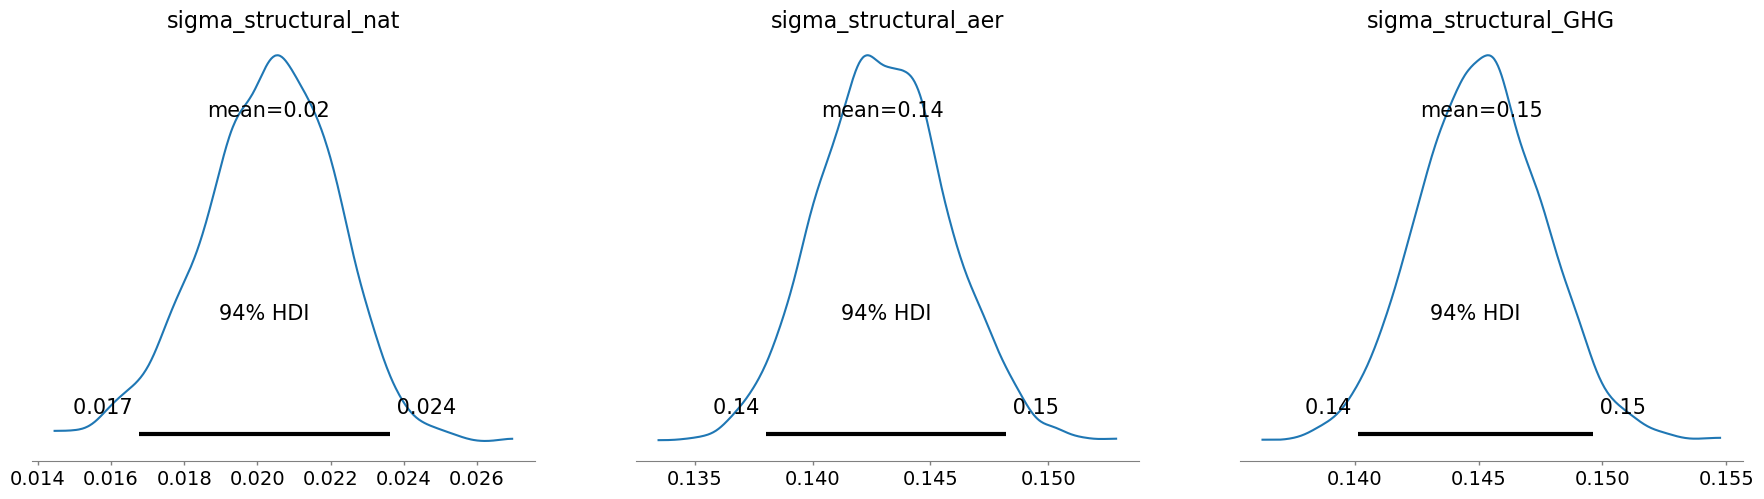

In [91]:
# Check the sigma_structural parameter
az.plot_posterior(trace,\
                  var_names=[f"sigma_structural_{fcg}" for fcg in ["nat","aer","GHG"]])

# Fingerprints
The fingerprints are determined from CMIP6 models.  This will be sensitive to the priors placed on structural spread in the CMIP6 models

## Aerosol Fingerprint 
The aerosol fingerprint is estimated from hist-aer simulations.  Note that this appears smaller than the CMIP6 mean and standard deviation.  This is correct!  When many models show essentially the same temporal response to a forcing, the uncertainty in the average forced response is smaller than the spread across individual models.  My posterior reflects uncertainty in the (latent) common signal.  Narrower doesn't mean overconfident in this case- it's a function of basically all the models having the same temporal behavior.

I'm not claiming that the true climate response lies within the envelope of CMIP models.  I'm estimating the uncertainty in the ensemble-informed fingerprint conditional on the assumption that models sample a common forced response.  The uncertainty arising from shared model biases or missing processes is not represented by the ensemble spread and is therefore not captured by this posterior.  

Text(0, 0.5, 'ΔT (°C)')

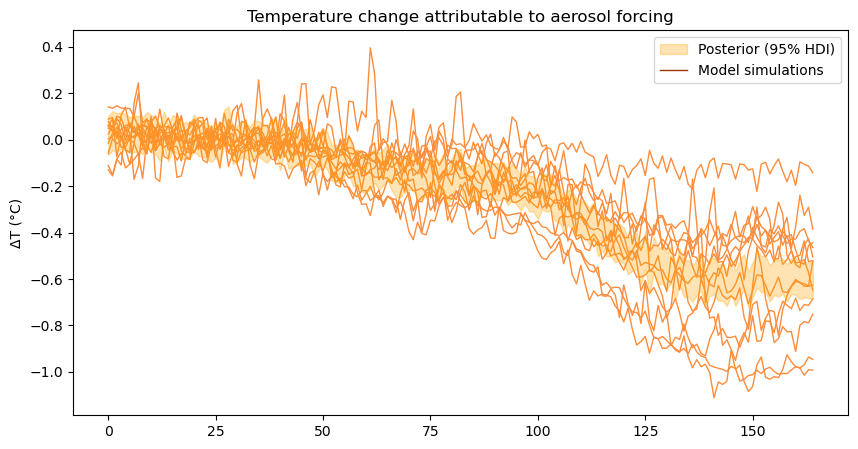

In [92]:
hdi_prob=.95
plt.figure(figsize=(10,5))
az.plot_hdi(time,trace.posterior.F_aer,
            hdi_prob=hdi_prob,
            smooth=False,
            color="orange",
           fill_kwargs={'label': 'Posterior (95% HDI)', 'alpha': apha})
for m in GCM_F["hist-aer"].keys():
    co2_ens=GCM_F["hist-aer"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Oranges(.5),zorder=0)
tmp,=plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Oranges(.9),zorder=0,label="Model simulations")
plt.legend()
tmp.set_visible(False)
plt.title("Temperature change attributable to aerosol forcing")
plt.ylabel("ΔT (°C)")

### Posteriors on scaling factors

array([<Axes: title={'center': 'beta_nat'}>,
       <Axes: title={'center': 'beta_aer'}>,
       <Axes: title={'center': 'beta_GHG'}>], dtype=object)

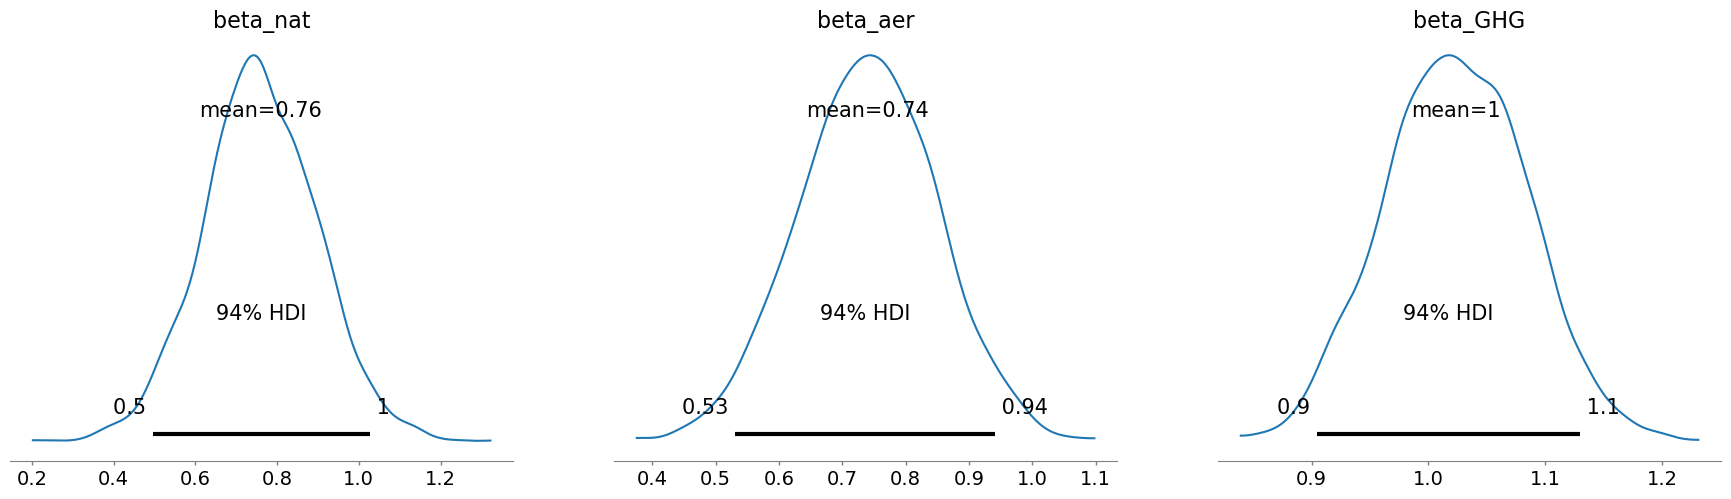

In [93]:
az.plot_posterior(trace,\
                  var_names=[f"beta_{fcg}" for fcg in ["nat","aer","GHG"]])

Text(0, 0.5, 'ΔT (°C)')

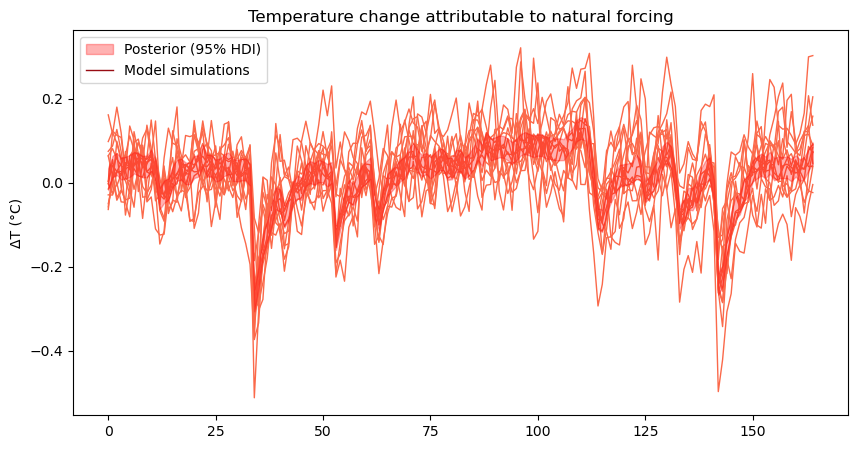

In [94]:
hdi_prob=.95
plt.figure(figsize=(10,5))
az.plot_hdi(time,trace.posterior.F_nat,
            hdi_prob=hdi_prob,
            smooth=False,
            color="red",
           fill_kwargs={'label': 'Posterior (95% HDI)', 'alpha': apha})
for m in GCM_F["hist-nat"].keys():
    co2_ens=GCM_F["hist-nat"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Reds(.5),zorder=0)
tmp,=plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Reds(.9),zorder=0,label="Model simulations")
plt.legend()
tmp.set_visible(False)
plt.title("Temperature change attributable to natural forcing")
plt.ylabel("ΔT (°C)")

## CO2
The CO2 fingerprint is estimated from 1) hist-CO2 simulations and 2) hist-GHG simulations, which we assume are the sum of hist-CO2 and hist-nonCO2

Text(0, 0.5, 'ΔT (°C)')

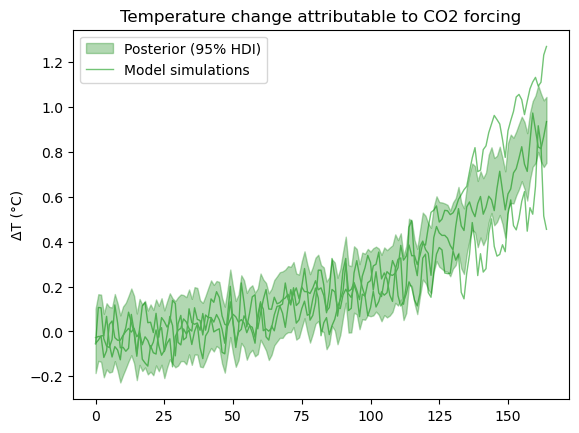

In [95]:
hdi_prob=.95

az.plot_hdi(time,trace.posterior.F_CO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'Posterior (95% HDI)', 'alpha': apha})
for m in GCM_F["hist-CO2"].keys():
    co2_ens=GCM_F["hist-CO2"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Greens(.5),zorder=0)
tmp,=plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Greens(.5),zorder=0,label="Model simulations")
plt.legend()
tmp.set_visible(False)
plt.title("Temperature change attributable to CO2 forcing")
plt.ylabel("ΔT (°C)")

# Correlated posteriors
The high correlation between the posteriors for $\beta_{GHG}$ and $\beta_{aer}$ reflects the epistemic uncertainty in how to assign the predictive power between two highly collinear forcings: as GHGs increase the temperature, aerosols decrease it.  So there are many combinations of $\beta_{GHG}$ and $\beta_{aer}$ that fit the data equally well.

The correlations of both with $\beta_{nat}$ are small- it's clear when and how much we can attribute observed global mean T variations to anthropogenic vs natural forcings.


In [96]:
aer2010=trace.posterior.attributable_aer.sel(time=2010).values.flatten()
co22010=trace.posterior.attributable_CO2.sel(time=2010).values.flatten()
nonCO22010=trace.posterior.attributable_nonCO2.sel(time=2010).values.flatten()

Text(0, 0.5, '2010 ΔT attributable to greenhouse gases (°C)')

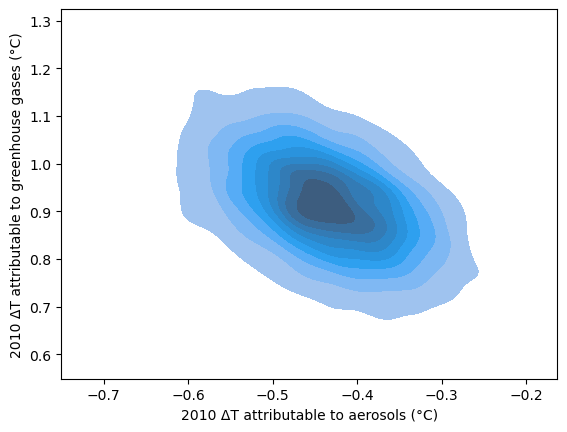

In [97]:
sns.kdeplot(x=aer2010,y=co22010,fill=True)
plt.xlabel("2010 ΔT attributable to aerosols (°C)")
plt.ylabel("2010 ΔT attributable to greenhouse gases (°C)")

In [98]:
ForcingColors={}
ForcingColors["CO2"]="green"
ForcingColors["nonCO2"]="purple"
ForcingColors["aer"]="orange"
ForcingColors["nat"]="red"

## Attributable warming
How much year-to-year warming is attributable to CO2 only?

Text(0.5, 1.0, 'Attributable warming relative to 1850-1900 baseline (95% HDI)')

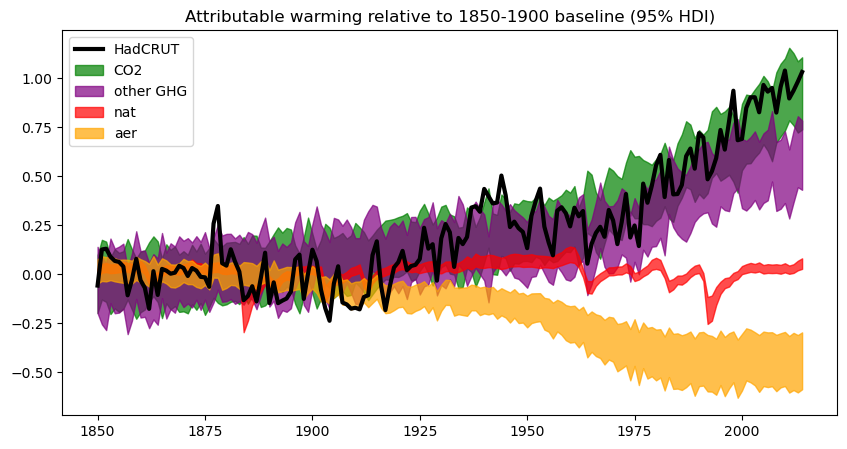

In [99]:
#tmp=[plt.plot(time,np.average(GCM_F["hist-CO2"][m],axis=0),c="g") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.attributable_all,smooth=False,color="g")
#az.plot_hdi(time,trace.posterior.F_historical,smooth=False,color="b")
plt.figure(figsize=(10,5))
hdi_prob=.95
time=np.arange(165)+1850
plt.plot(time,H_obs.values,c=obsc,lw=3,label="HadCRUT",zorder=4)
az.plot_hdi(time,trace.posterior.attributable_CO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'CO2', 'alpha': 0.7})
az.plot_hdi(time,trace.posterior.attributable_nonCO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="purple",
           fill_kwargs={'label': 'other GHG', 'alpha': 0.7})

az.plot_hdi(time,trace.posterior.attributable_nat,
            hdi_prob=hdi_prob,
            smooth=False,
            color="red",
           fill_kwargs={'label': 'nat', 'alpha': 0.7})

az.plot_hdi(time,trace.posterior.attributable_aer,
            hdi_prob=hdi_prob,
            smooth=False,
            color="orange",
           fill_kwargs={'label': 'aer', 'alpha': 0.7})
plt.legend()
plt.title(f"Attributable warming relative to 1850-1900 baseline ({str(int(hdi_prob*100))}% HDI)")
#tmp=[plt.plot(time,np.average(GCM_F["hist-GHG"][m],axis=0)-np.average(GCM_F["hist-CO2"][m],axis=0),c="b") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.F_nonCO2,smooth=False,color="b")

Another way to visualize this: stack the posterior mean contributions from each forcing.  This way we can see that CO2 and non-CO2 GHGs warm, but the contribution of non-CO2 GHGs is largely offset by aerosols.

In [106]:
def barplot(trace,all_experiments=["CO2","nat","aer","nonCO2"],for_talk=False):
    if for_talk:
        obscolor="w"
    else:
        obscolor="k"
    T=trace.posterior.F_aer.time+1850

    posbottom=np.zeros_like(T)
    negbottom=np.zeros_like(T)
    
    for experiment in all_experiments:
        just_exp=getattr(trace.posterior,"attributable_"+experiment).mean(dim=["chain","draw"]).to_numpy()
        plt.bar(T,just_exp,bottom=np.where(just_exp>0,posbottom,negbottom),color=ForcingColors[experiment],\
              label=experiment,edgecolor="w",lw=.2)#, edgecolor=ForcingColors[experiment])

        posbottom=np.where(just_exp>0,posbottom+just_exp,posbottom)
        negbottom=np.where(just_exp<0,negbottom+just_exp,negbottom)
    

    plt.plot(T,H_obs.values,c=obscolor,lw=2,label="HadCRUT")
    
    plt.legend(ncol=2)

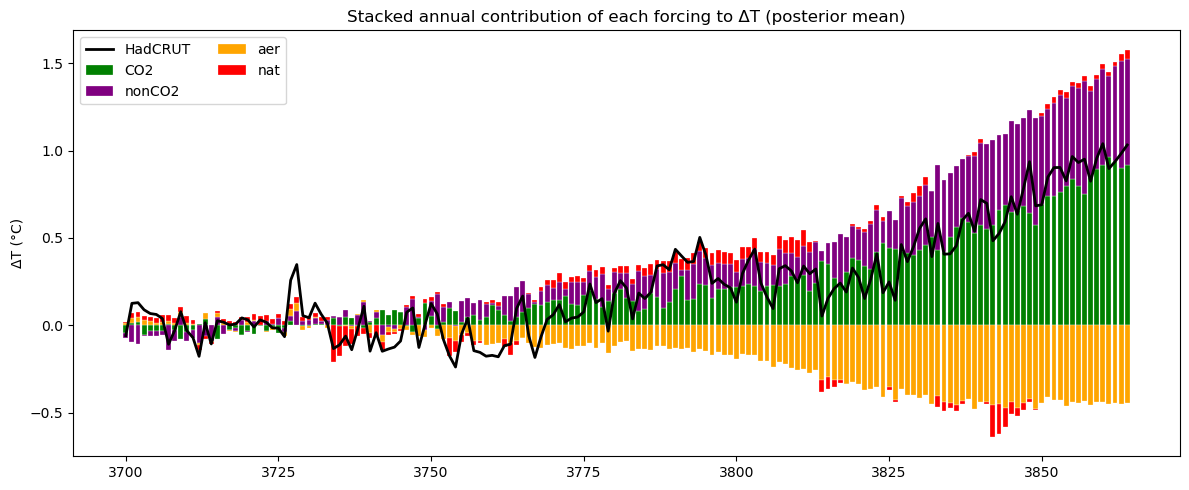

In [101]:
plt.figure(figsize=(12,5))
barplot(trace,all_experiments=["CO2","nonCO2","aer","nat"])
plt.title("Stacked annual contribution of each forcing to ΔT (posterior mean)")
plt.ylabel("ΔT (°C)")
plt.tight_layout()

# TCRE
The transient climate response to emissions (TCRE) is derived from the temperature change attributable to CO2 and the emissions.  We use the entire time series and estimate TCRE as the OLS slope through the origin of $T_{CO2}$ on $E$.  Mathematically, we have 
$$ P(TCRE | data) = \int \delta(TCRE - f(T_{CO2},E))p(T_{CO2},E| data)\,dT_{CO2} dE$$

where $$f(T_{CO2}, E) = \frac{\sum_{t}E(t) T_{CO2}(t)}{E(t)^2}$$

This posterior reflects the historically realized TCRE, conditional on the observed temperature record and the ensemble-informed forced response, rather than the broader range of TCRE consistent with all possible climate realizations and emission pathways.

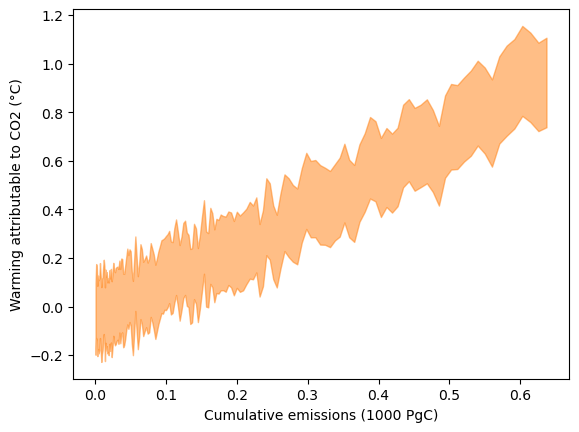

In [107]:
az.plot_hdi(mu_E,trace.posterior.attributable_CO2,smooth=False,hdi_prob=.95)
tmp=plt.xlabel("Cumulative emissions (1000 PgC)")
tmp=plt.ylabel("Warming attributable to CO2 (°C)")

Estimate of TCRE from the slope

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TCRE,1.383,0.085,1.227,1.546,0.002,0.001,1764.0,2423.0,1.0


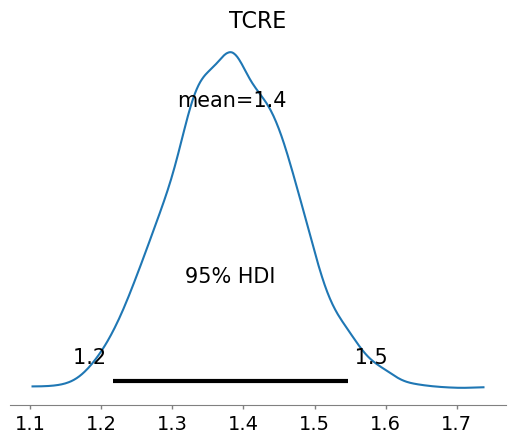

In [103]:
az.plot_posterior(trace,var_names=["TCRE"],hdi_prob=.95)
az.summary(trace,var_names=["TCRE"])

Note that this gives us a more confident answer than simply taking the ratio in the last year.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.436,0.15,1.164,1.723,0.003,0.002,3262.0,2984.0,1.0


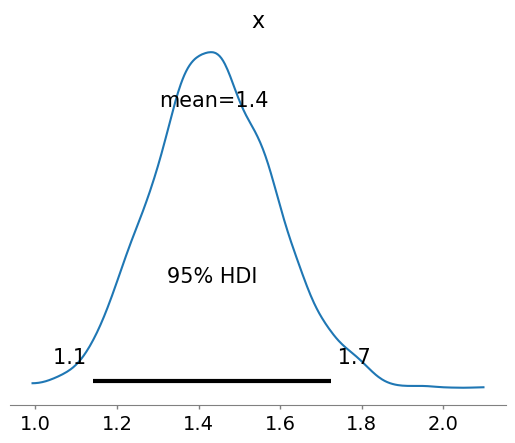

In [105]:
az.plot_posterior(trace.posterior.attributable_CO2.isel(time=-1)/
                  trace.posterior.E_cum.isel(time=-1),hdi_prob=.95)
az.summary(trace.posterior.attributable_CO2.isel(time=-1)/
                  trace.posterior.E_cum.isel(time=-1))

# Scratchwork

## Does concatenating piControl runs introduce spurious noise?
No, if we stack the last 170 years (shortest CMIP6 control run length) of each run, the posteriors are fairly identical.

In [ ]:
C_stack=np.stack([GCM_F["piControl"][model][-170:] for model in GCM_F["piControl"].keys()])

n_ar=3

with pm.Model() as ARstack:
    rho=pm.Uniform("rho",-1,1,shape=(n_ar))
    sigma_innov=pm.HalfNormal("sigma_innov",10)
    pm.AR("lik",rho=rho,sigma=sigma_innov,observed=C_stack)
    ARstack_trace=pm.sample()
az.plot_posterior(ARstack_trace)

## Can we use a gaussian process to more accurately characterize the noise?
Not really, and anyway the sampling from a GP-parameterized covariance matrix takes too long

In [ ]:
fit_a_GP=False
if fit_a_GP:
    # GAUSSIAN PROCESS
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel

    # --- Define kernels for each timescale ---

    # Short-term: year-to-year (1–2 years)
    kernel_short = 1.0 * RBF(length_scale=1.0)

    # Medium-term: decadal (~10 years)
    kernel_medium = 1.0 * RBF(length_scale=10.0)

    # Long-term: halfcentennial (~50 years)
    kernel_long = 1.0 * RBF(length_scale=50.0)

    # Noise kernel
    noise_kernel = WhiteKernel(noise_level=0.1)

    # Combine all kernels
    kernel = kernel_short + kernel_medium + kernel_long + noise_kernel

    # --- Build and fit GP model ---
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

    gp.fit(t_c.reshape(-1, 1), C_conc.reshape(-1, 1))
    # Parse out parameters (will have to do by hand)
    opt_kernel = gp.kernel_